# 01 - Read TEC Data

Notebook para cargar los datos usando las funciones de `data_utils.py` y mostrar algunas estadisticas

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from pathlib import Path 
import logging

import data_utils

# Set logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

In [2]:
from data_utils import load_tec_data

# Load Data
datafolder = Path("tucu")
year = 2000
df = load_tec_data(year, datafolder)

Tamaño de la serie: 1054080
Porcentaje de NaNs: 0.703%
7412 NaNs y 1046668 Valores no nulos.


array([<Axes: >, <Axes: >], dtype=object)

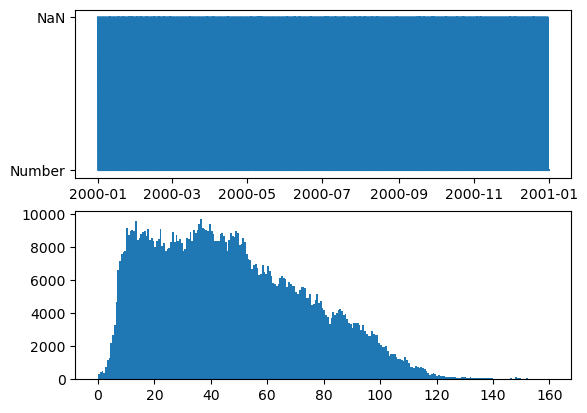

In [3]:
from data_utils import basic_stats

basic_stats(df.tec)

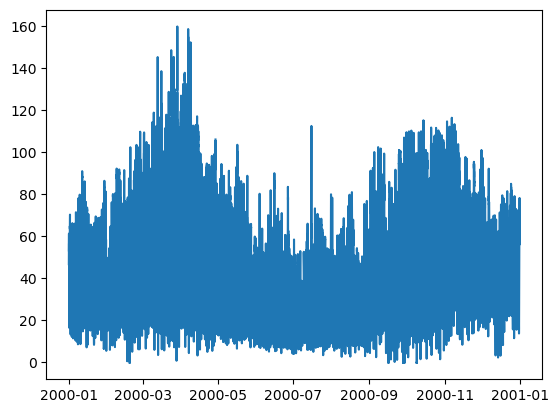

In [4]:
import matplotlib.pyplot as plt 

plt.plot(df.tec)

## Resample & Interpolate Data

Tamaño de la serie: 527040
Porcentaje de NaNs: 0.628%
3311 NaNs y 523729 Valores no nulos.


array([<Axes: >, <Axes: >], dtype=object)

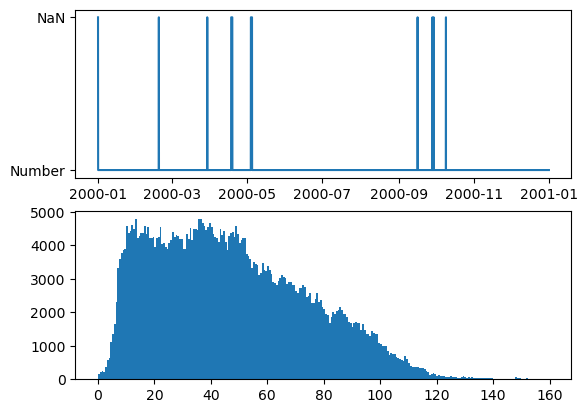

In [5]:
from datetime import timedelta

tec = df.resample(rule=timedelta(0,60)).asfreq() # resample to 60s
tec = tec.interpolate(method="linear", limit=1) # interpolate missing values 

data_utils.basic_stats(tec.tec)

## No-gap Selection

Tamaño de la serie: 191520
Porcentaje de NaNs: 0.000%
0 NaNs y 191520 Valores no nulos.


array([<Axes: >, <Axes: >], dtype=object)

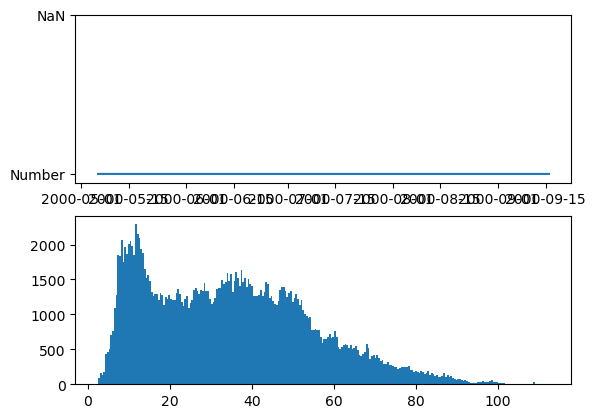

In [43]:
start_date = f"{year}-05-06"
end_date = f"{year}-09-15"
tec_selection = tec.loc[start_date:end_date]
data_utils.basic_stats(tec_selection.tec)

# 02 - Load SYM-H

In [7]:
symh = data_utils.load_symh_wdc(f"sym/ASY-SYM-WDCformat-{year}.dat")

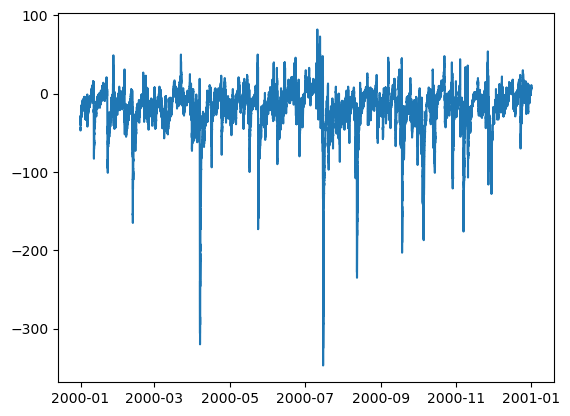

In [8]:
plt.plot(symh.symh)

# 03 - Merge TEC & SYM-H

<Axes: xlabel='datetime'>

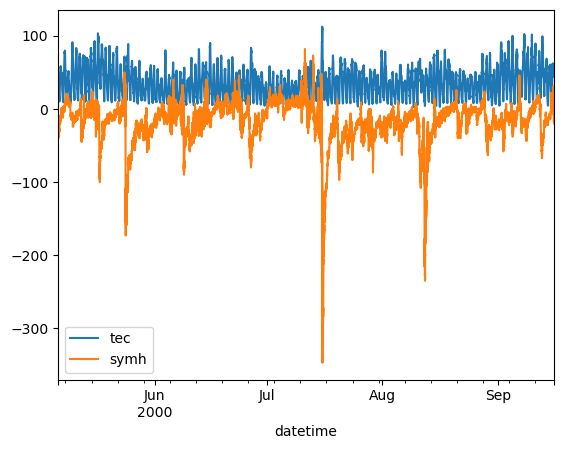

In [41]:
df = pd.merge(left=tec_selection, 
         right=symh, 
         #left_on=tec_selection.index,
         right_on=symh.index, 
         how="left",left_index=True).loc[:,["tec", "symh"]]

df.plot()

In [44]:
df.to_csv(f"tec-symh-{start_date}-{end_date}.csv")

# OLD STUFF

In [9]:
def print_gaps_lengths(series):
    """Print lengths of gaps of nans longer than 1
    """
    lengths = "".join(np.array(series.isna()).astype(int).astype("str")).split("0")
    for l in lengths:
        if not l:
            continue 
        if (w:=len(l)) > 1:
            print(w)

print_gaps_lengths(tec.tec)

137
34
1440
1440
11
12
46
104
58
28


In [10]:
import logging

def get_nan_lengths(df, col="tec"):
    #dfs = []
    nans = df[col].isna()
    aux_index = np.arange(df[col].size).astype(str)
    aux_index[nans] = "n"   
    test_list = "-".join(aux_index).split("n")

    dfs = []

    for item in test_list:
        if item == "-":
            continue
        t = item.split("-")
        while "" in t:
            t.remove("")
        dfs.append(df.iloc[np.array(t).astype(int)])
    logging.info(f"DataFrame separado en {len(dfs)} DataFrames.")
    return dfs

test_df = pd.DataFrame({"tec": [1, 2, 3, None, None, 4, 5, None, 7]})
